In [8]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación del Dataset
irisDataset = pd.read_csv("data/iris.data", names=["sepallength","sepalwidth","petallength","petalwidth","class"])
irisDataset

,sepallength,sepalwidth,petallength,petalwidth,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


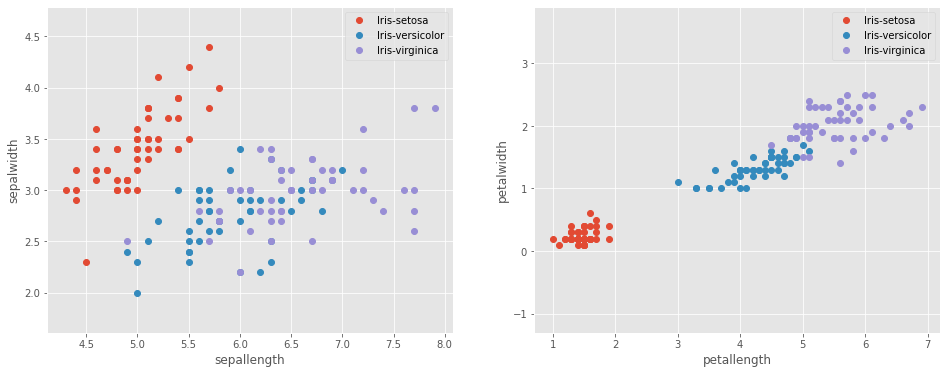

In [3]:
# Grafico concentración del tipo de flor segun largo y ancho del sépalo
import matplotlib.pyplot as plt
plt.style.use('ggplot')
nomeClases = irisDataset["class"].unique()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax1.plot(X_plot["sepallength"], X_plot["sepalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel("sepallength")
ax1.set_ylabel("sepalwidth")
ax1.axis('equal')
ax1.legend()
for target, target_name in enumerate(nomeClases):
    X_plot = irisDataset[irisDataset["class"] == target_name]
    ax2.plot(X_plot["petallength"], X_plot["petalwidth"], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel("petallength")
ax2.set_ylabel("petalwidth")
ax2.axis('equal')
ax2.legend()

In [4]:
# Transformaciones (en la presentación Iris e Pytorch)
class StandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)
        

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

In [5]:
import torch
from torch.utils.data import Dataset

class IrisDataset(Dataset):
  def __init__(self, src_file, root_dir, transform=None):
    irisDataset = pd.read_csv(src_file, names=["sepallength","sepalwidth","petallength","petalwidth","class"])
    X = irisDataset[irisDataset.columns.intersection(["sepallength","sepalwidth","petallength","petalwidth"])]
    Y = irisDataset[irisDataset.columns.intersection(["class"])]
    nomeClases = Y["class"].unique()
    conversion = {v: k for k, v in dict(enumerate(nomeClases)).items()}
    YConversion = pd.DataFrame()
    for nome in nomeClases:
      YConversion[nome] = (Y["class"]==nome).apply(lambda x : 1.0 if x else 0.0)
    
    y_tensor = torch.as_tensor(YConversion.to_numpy()).type(torch.float32)
    df_dict = dict.fromkeys(X.columns, '')
    X.rename(columns = df_dict)
    s1=X.iloc[:,0:4].values
    x_tensor = torch.tensor(s1)
    scaler = StandardScaler()
    scaler.fit(x_tensor)
    XScalada = scaler.fit_transform(x_tensor).type(torch.float32)
    self.data = torch.cat((XScalada,y_tensor),1)
    self.root_dir = root_dir
    self.transform = transform
    
  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    preds = self.data[idx, 0:4]
    spcs = self.data[idx, 4:]
    sample = (preds, spcs)
    if self.transform:
      sample = self.transform(sample)
    return sample  


In [6]:
# Carga de datos y comprobación de funcionamiento
dataset = IrisDataset("data/iris.data",".")
display(dataset[0]) 

(tensor([-0.8977,  1.0286, -1.3368, -1.3086]), tensor([1., 0., 0.]))

In [9]:
# División en train y test
from torch.utils.data import random_split

lonxitudeDataset = len(dataset)
tamTrain =int(lonxitudeDataset*0.8)
tamVal = lonxitudeDataset - tamTrain
print(f"Tam dataset: {lonxitudeDataset} train: {tamTrain} tamVal: {tamVal}")
train_set, val_set = random_split(dataset,[tamTrain,tamVal])
train_ldr = torch.utils.data.DataLoader(train_set, batch_size=2,
    shuffle=True, drop_last=False)
validation_loader =torch.utils.data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)


Tam dataset: 150 train: 120 tamVal: 30


In [10]:
import torch.nn.functional as F
import torch.nn as nn
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(in_features=50, out_features=3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x


In [11]:
# Implementación del modelo 
model     = Model(4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
display(model)

Model(
  (layer1): Linear(in_features=4, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)

In [12]:
# Prueba
entradaProba,dest = next(iter(train_ldr))
print("Entrada:")
display(entradaProba)
print("Deseada:")
display(dest)
saida = model(entradaProba) # esta é a proba de verdade
print("Salida:")
display(saida)
loss_fn(saida, dest)

Entrada:


tensor([[-0.1731,  3.1043, -1.2801, -1.0465],
        [-0.1731, -0.5858,  0.1935,  0.1328]])

Deseada:


tensor([[1., 0., 0.],
        [0., 1., 0.]])

Salida:


tensor([[0.2681, 0.3959, 0.3360],
        [0.3505, 0.3561, 0.2935]], grad_fn=<SoftmaxBackward0>)

tensor(1.1208, grad_fn=<DivBackward1>)

## **Entrenamiento**

In [13]:

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(train_ldr) instead of
    # iter(train_ldr) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_ldr):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss



In [14]:
EPOCHS = 100
loss_list = torch.zeros((EPOCHS,))
accuracy_list = torch.zeros((EPOCHS,))

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch + 1))

    # Ponemos el modelo en modo entrenamento
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    loss_list[epoch] = avg_loss
    # No se precisan los gradientes para o test
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)

        correct = (torch.argmax(voutputs, dim=0) == vlabels).type(torch.FloatTensor)
        accuracy_list[epoch] += correct.sum()
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {} {}/{}'.format(avg_loss, avg_vloss,accuracy_list[epoch],int(lonxitudeDataset*0.2)))

EPOCH 1:
  batch 10 loss: 1.1041622161865234
  batch 20 loss: 1.0811797022819518
  batch 30 loss: 1.05477135181427
  batch 40 loss: 1.0249763667583465
  batch 50 loss: 1.0041927814483642
  batch 60 loss: 0.9266839146614074
LOSS train 0.9266839146614074 valid 0.9313875436782837 20.0/30
EPOCH 2:
  batch 10 loss: 0.9219310641288757
  batch 20 loss: 0.835835438966751
  batch 30 loss: 0.8938529849052429
  batch 40 loss: 0.760423356294632
  batch 50 loss: 0.8558512032032013
  batch 60 loss: 0.7613441288471222
LOSS train 0.7613441288471222 valid 0.7519432306289673 20.0/30
EPOCH 3:
  batch 10 loss: 0.8465612709522248
  batch 20 loss: 0.7029744148254394
  batch 30 loss: 0.7037398338317871
  batch 40 loss: 0.6987643361091613
  batch 50 loss: 0.7427073180675506
  batch 60 loss: 0.7075626075267791
LOSS train 0.7075626075267791 valid 0.667466938495636 20.0/30
EPOCH 4:
  batch 10 loss: 0.6561507284641266
  batch 20 loss: 0.6668562591075897
  batch 30 loss: 0.7175761342048645
  batch 40 loss: 0.67302

Text(0.5, 0, 'epochs')

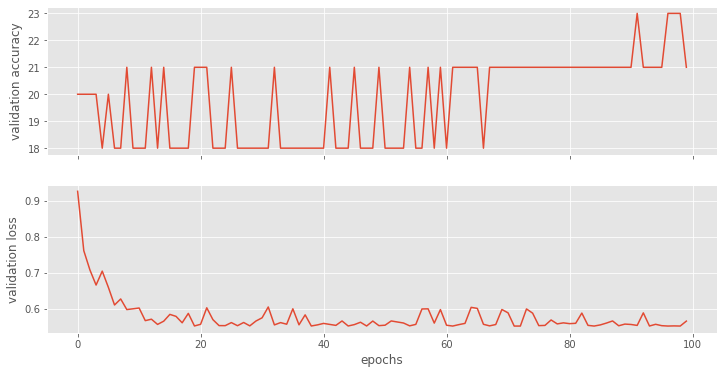

In [15]:
# Gráfica accuracy y pérdida
import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs")